<a href="https://colab.research.google.com/github/rohitreddynagareddy/132test/blob/master/Copy_of_GRPO_(reasoning_fine_tuning)_on_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credits:

OG GRPO Script (Will Brown) - https://gist.github.com/willccbb/4676755236bb08cab5f4e54a0475d6fb

Main Author of Colab (on Base Model) - Pierre-Carl Langlais https://www.linkedin.com/feed/update/urn:li:activity:7292140318496362496/

Colab GRPO with Instruct Model (Pierre-Carl Langlais) - https://www.linkedin.com/feed/update/urn:li:activity:7291769154028597248/

Oleksandr Parshakov - This notebook
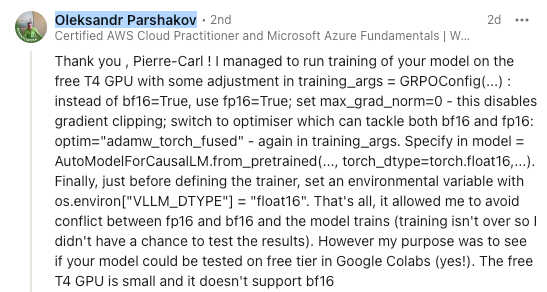



<h3 align="center"></h3>

<h1 align="center">Qwen 0.5b on GRPO</h1>

---

<h1 align="center">Training a small math reasoner with RL</h1>

This notebook is an alternate version of the [GRPO demo](https://gist.github.com/willccbb/4676755236bb08cab5f4e54a0475d6fb) by [will brown,](https://x.com/willccbb) training llama-1b on the gsm8k math dataset.

We've only implemented a series of changes to make the code more workable on Colab:
* Replacement of llama-1b with Qwen-0.5b
* Generation with vllm, which yields a significant speed-up. Qwen small size makes it possible to run vllm on the same gpu as the one being used for GRPO.
* Dropping flash-attn (recurrent bug with modeling qwen, not clear why)

## Setting up the models.

First we install vllm. Notice that you'll have to restart the session afterwards.

In [ ]:
!pip install vllm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.2/264.2 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.

Then we install trl and datasets. It has to be in this order for some reason (bug on trl if you do vllm afterwards)

In [ ]:
!pip install trl datasets

  Using cached trl-0.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.9/313.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Unins

## Defining the RL rewards

Now we have everything ready to set up our RL training set and reward policy.

First we set the general prompt structure (with the reasoning tags).

In [ ]:
import re
import torch
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import GRPOConfig, GRPOTrainer

# Load and prep dataset

SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

XML_COT_FORMAT = """\
<reasoning>
{reasoning}
</reasoning>
<answer>
{answer}
</answer>
"""

INFO 02-04 19:44:13 __init__.py:183] Automatically detected platform cuda.


Now we import the gsm8k dataset and restructure it to fit into a conversational prompt format:

In [ ]:
def extract_xml_answer(text: str) -> str:
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()

def extract_hash_answer(text: str) -> str | None:
    if "####" not in text:
        return None
    return text.split("####")[1].strip()

# uncomment middle messages for 1-shot prompting
def get_gsm8k_questions(split = "train") -> Dataset:
    data = load_dataset('openai/gsm8k', 'main')[split] # type: ignore
    data = data.map(lambda x: { # type: ignore
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['question']}
        ],
        'answer': extract_hash_answer(x['answer'])
    }) # type: ignore
    return data # type: ignore

dataset = get_gsm8k_questions()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

# Reward Functions

We move on now to the reward functions. The most important one is the "correctness" function which acts as a verifier (comparison of model completions vs. answer). The three others are formatting functions.

`correctness_reward_func`: Compares extracted answers from model completions with the correct answer and assigns a reward of 2.0 for a match, otherwise 0.0.

`int_reward_func`: Checks if the extracted response is a digit and assigns a reward of 0.5 if true, otherwise 0.0.

`strict_format_reward_func`: Verifies if the response strictly follows a predefined XML format and assigns 0.5 if it matches, otherwise 0.0.

`soft_format_reward_func`: Loosely checks if the response contains <reasoning>...</reasoning> and <answer>...</answer> and assigns 0.5 if found, otherwise 0.0.

`count_xml`: Evaluates how well the response follows XML formatting by checking occurrences of specific XML tags and reducing the score if extra text appears after </answer>.

`xmlcount_reward_func`: Applies count_xml to each response in the completions and returns a list of XML format scores.

In [ ]:
# Reward functions
def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_responses = [extract_xml_answer(r) for r in responses]
    print('-'*20, f"Question:\n{q}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}")
    return [2.0 if r == a else 0.0 for r, a in zip(extracted_responses, answer)]

def int_reward_func(completions, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    return [0.5 if r.isdigit() else 0.0 for r in extracted_responses]

def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def count_xml(text) -> float:
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.125
    if text.count("\n</reasoning>\n") == 1:
        count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1])*0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1)*0.001
    return count

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    contents = [completion[0]["content"] for completion in completions]
    return [count_xml(c) for c in contents]

We now set the training arguments:

In [ ]:
model_name = "HuggingFaceTB/SmolLM2-135M-Instruct" #"Qwen/Qwen2.5-0.5B-Instruct"

output_dir="outputs/SmolLM2-135M-GRPO"
run_name="HuggingFaceTB/SmolLM2-135M-Instruct-GRPO-gsm8k"

training_args = GRPOConfig(
    output_dir=output_dir,
    run_name=run_name,
    learning_rate=5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type='cosine',
    logging_steps=1,
    fp16=True,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_generations=16,
    max_prompt_length=256,
    max_completion_length=200,
    num_train_epochs=1,
    save_steps=100,
    max_grad_norm=0.1,
    log_on_each_node=False,
    use_vllm=True,
    vllm_gpu_memory_utilization=.3,
    vllm_device="cuda:0",
    report_to="none" #I'm disabling Wandb.
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map=None
).to("cuda")

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
1
Tesla T4


And launch the actual training:

In [ ]:
model_name = "HuggingFaceTB/SmolLM2-135M-Instruct" #"Qwen/Qwen2.5-0.5B-Instruct"

output_dir="outputs/SmolLM2-135M-GRPO"
run_name="HuggingFaceTB/SmolLM2-135M-Instruct-GRPO-gsm8k"

training_args = GRPOConfig(
    output_dir=output_dir,
    run_name=run_name,
    optim="adamw_torch_fused", ######
    learning_rate=5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.2, # increased L2 weight regularisation - because
    warmup_ratio = 0.1,
    lr_scheduler_type='cosine',
    logging_steps=1,
    fp16=True, ####
    per_device_train_batch_size=1,
    gradient_accumulation_steps=2,
    num_generations=8,
    max_prompt_length=128,
    max_completion_length=100,
    num_train_epochs=1,
    save_steps=100,
    max_grad_norm=0, # disables gradient clipping
    log_on_each_node=False,
    use_vllm=False,
    vllm_gpu_memory_utilization=.3,
    vllm_device="cuda:0",
    report_to="wandb" #I'm disabling Wandb.
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16, #####
    device_map=None
).to("cuda")


tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

import os
os.environ["VLLM_DTYPE"] = "float16" #####

trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
        int_reward_func,
        correctness_reward_func],
    args=training_args,
    train_dataset=dataset,
    #peft_config=peft_config
)
trainer.train()

-------------------- Question:
Ahmed and Emily are having a contest to see who can get the best grade in the class. There have been 9 assignments and Ahmed has a 91 in the class. Emily has a 92. The final assignment is worth the same amount as all the other assignments. Emily got a 90 on the final assignment. What is the minimum grade Ahmed needs to get to beat Emily if all grades are whole numbers? 
Answer:
100 
Response:
To find the minimum grade Ahmed needs to get to beat Emily if all grades are whole numbers, we first need to calculate the average of Emily's and Ahmed's grades. Since Emily has a 91 on the final assignment, we need to find the average of her grades and then add 2 points to it. 

First, let's add the two averages together: 91 + 91 = 102. 

Now, we need to find out how many 
Extracted:
To find the minimum grade Ahmed needs to get to beat Emily if all grades are whole numbers, we first need to calculate the average of Emily's and Ahmed's grades. Since Emily has a 91 on

Step,Training Loss
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000


-------------------- Question:
There are 15 tables in the school's cafeteria. Each table can seat 10 people. Usually, only 1/10 of the seats are left unseated. How many seats are usually taken? 
Answer:
135 
Response:
There are 14 tables in the school's cafeteria. Each table can seat 10 people. So, there are 14 tables * 10 people per table = 140 seats taken.

The problem states that at least one of the seats is unseated, so there is one seat for each person, but it does not say that the seat was unseated, only that it was unseated. The problem can be simplified by recognizing that the given information suggests 
Extracted:
There are 14 tables in the school's cafeteria. Each table can seat 10 people. So, there are 14 tables * 10 people per table = 140 seats taken.

The problem states that at least one of the seats is unseated, so there is one seat for each person, but it does not say that the seat was unseated, only that it was unseated. The problem can be simplified by recognizing that